In [3]:
import osiris
import numpy as np
import matplotlib.pyplot as plt
from mpmath import *
%matplotlib inline

title_font = {'fontname':'Arial', 'size':'20', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}
axis_font = {'fontname':'Arial', 'size':'34'}
plt.rc('font',size=20,family="serif")


# Buneman instability

Consider a stationary background of ions with the electron plasma moving with a constant drift velocity $\vec{v}_0$. This could be produced, for example, by a current-carrying plasma. Then the dispersion relation is reduced to

$$ 
1 = \omega_{pe}^2 \left(\frac{m_e/m_i}{\omega^2} + \frac{1}{(\omega - \vec{k} \cdot \vec{v}_0)^2}\right).
$$ 

This quartic equation can be cast into a simpler form by defining $x \equiv \omega/\omega_{pe}$ and $\alpha \equiv \vec{k} \cdot \vec{v}_0/\omega_{pe}$ to get

$$ 
1 = \frac{m_e/m_i}{x^2} + \frac{1}{(x-\alpha)^2}.
$$ 

#### Parameters

From the above equation, it is seen that the two free parameters in the problem are the ratio of electron to ion mass, $m_e/m_i$, and $\alpha = \vec{k} \cdot \vec{v}_0/\omega_{pe}$, or simply the ratio $\vec{k} \cdot \vec{v}_0/n_0$.

#### Solution to the dispersion relation

If we define the right-hand side of the equation as

$$ 
f(x) = \frac{m_e/m_i}{x^2} + \frac{1}{(x-\alpha)^2},
$$ 

then we seek for solutions to $f(x) = 1$. In the below figure, we see that two of the roots for $\omega$ are always real, and the other two roots may be real or complex depending on the value of $\alpha$. To find when the $\omega$ roots begin to be complex, we seek to minimize $f(x)$. Setting $\frac{m_e}{m_i} \approx \frac{1}{1836}$ and solving $f'(x)=0$ yields $x_{min} \approx 0.75\alpha$. Then setting $f(x_{min}) \geq 1$ means that to have complex roots we need $\alpha \lesssim 1.12$. This is shown in the red curve in the below figure.

<img src="two_stream_disp.png">

If we let $\omega = \omega_R+i \omega_I$, then solving for $\omega_I$ gives the growth rate. The real and imaginary parts of the frequency are shown in the below figure.

<img src="omega_roots.png">

## Here we calculate the universal growth curve for a given mass ratio.  The theory curve works for a given mass ratio as a function of $\alpha$.  For the same mass ratio one can change the beam velocity and produce a theory curve for any electron beam velocity, which we will do in a cell below

## We will also explore the possibility of producing the roots outside of python and read it in as a table.

In [17]:
# Here we calculate the growth rate via root finder, and define an interpolation function:

import numpy as np
from scipy.optimize import minimize as mini
from scipy.optimize import fsolve
# from mpmath import findroot as fr
# from sympy import sympify as sym
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d



#
#
# THIS IS THE MASS RATIO.
#
#

c=1/100

#
#
#
#
#

funalpha1 = lambda x: c/x**2 + 1/(x-1)**2
xmin = mini(funalpha1,0.1,bounds=[(1e-6,2)]).x
fun1 = lambda alpha: c/xmin**2 + 1/(xmin-alpha)**2 - 1
# alphac = fsolve(fun1,1)
alpha_max = xmin+xmin**2/np.sqrt(xmin**4-c*xmin**2)
N=200
alpha=np.linspace(alpha_max/(N+1),alpha_max,N)
x0=(0.00001,0.00001)
w=np.zeros(N,dtype=complex)
for i in np.arange(N):
    def equations(p):
        x, y = p
        return (c/(x**2+y**2)-2*c*y**2/(x**2+y**2)**2 + 
                ((x**2+y**2)-2*y**2+alpha[i]*(alpha[i]-2*x))/
                ((x**2+y**2)+alpha[i]*(alpha[i]-2*x))**2-1,
               2*y*((alpha[i]-x)/((x**2+y**2)+alpha[i]*(alpha[i]-2*x))**2-
                   c*x/(x**2+y**2)**2))

    x, y =  fsolve(equations, x0)
    x0=(x,y)
    w[i]=x+y*1j

# plt.plot(alpha,w.real,alpha,w.imag)
# plt.show()

growth_rate_func=interp1d(alpha,w.imag,kind='cubic')

## Here we produce the theory curve for our particular simulation, which has a beam velocity of 3 $\Delta x \omega_{pe}$.

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


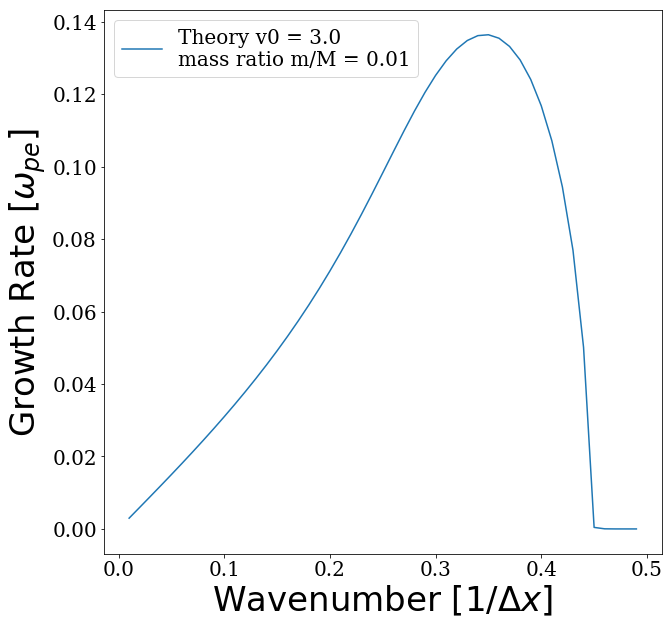

In [18]:
v0=3.0

karray=np.arange(0.01,0.5,0.01)
nk=49
growth_rate=np.zeros(nk)
growth_rate=growth_rate_func(karray*v0)
plt.figure(figsize=(10,10))
plt.plot(karray,growth_rate,label='Theory v0 = '+repr(v0)+'\n'+'mass ratio m/M = '+repr(c))

plt.xlabel('Wavenumber [$1/\Delta x$]',**axis_font)
plt.ylabel('Growth Rate [$\omega_{pe}$]',**axis_font)
plt.legend()
plt.show()

In [2]:
dirname = 'buneman'
osiris.run_upic_es(rundir=dirname,inputfile='buneman.txt')

combine_h5_2d completed normally
runbeps completed normally


/home/jovyan/work/M185-pre-Oct15/two-stream/buneman/Ex.h5


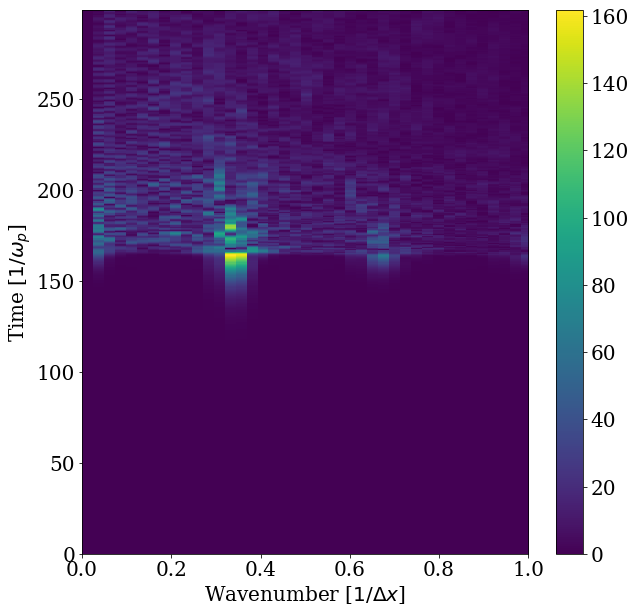

In [6]:
# read the history file, plot it vs time and space
from analysis import *
from h5_utilities import *
import os
workdir = os.getcwd()
dirname ='buneman'
filename=workdir+'/'+dirname+'/Ex.h5'
print(filename)
test4=read_hdf(filename)
# here we fourier analyze the data in space
#
# k_data=np.fft.fft(test.data,axis=1)
k_data=np.fft.fft(test4.data,axis=1)
# k_data_2=np.fft.fft(k_data,axis=0)

test4.data=np.abs(k_data)

test4.axes[0].axis_max=2.0*3.1415926


# test4.data=np.log10(np.real(test4.data)+1e-10)
plt.figure(figsize=(10,10))
plotme(test4)
plt.xlim(0,1)
plt.xlabel('Wavenumber [$1/\Delta x$]')
plt.ylabel('Time [$1/\omega_p$]')
# plt.ylim(0,50)
# plt.ylim(tlim[0],tlim[1])
plt.show()

## The most unstable mode occurs at mode 14, the theory agrees well for modes 8-14

Delta k = 0.0245436921875


/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


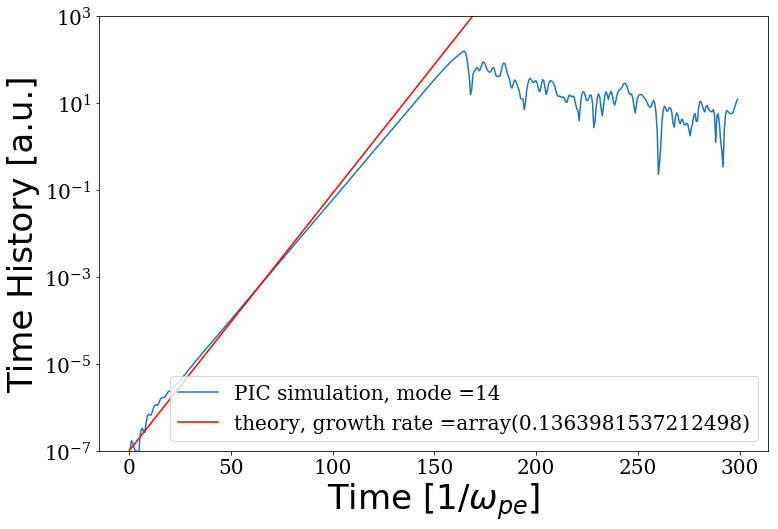

In [14]:
# This cell we try to compare data with theory:

nx=test4.data.shape[1]
nt=test4.data.shape[0]
# print(repr(nt))
dk=2*3.1415926/nx
print('Delta k = '+repr(dk))


# To compare with theory, just specify the mode you want to look at here
#
display_mode = 14
bracket = False
#
#

v0=3.0

alpha = v0 * dk * (display_mode)
# growth_rate = 0.0
# if (alpha<np.sqrt(2)): 
growth_rate=growth_rate_func(alpha)

taxis=np.linspace(0,test4.axes[1].axis_max,nt)
stream_theory=np.zeros(nt)
stream_theory_plus=np.zeros(nt)
stream_theory_minus=np.zeros(nt)
init_amplitude=1e-7
for it in range(0,nt):
    stream_theory[it]=init_amplitude*np.exp(growth_rate*taxis[it])
    stream_theory_plus[it]=init_amplitude*np.exp(1.15*growth_rate*taxis[it])
    stream_theory_minus[it]=init_amplitude*np.exp(0.85*growth_rate*taxis[it])

plt.figure(figsize=(12,8))
plt.semilogy(taxis,test4.data[:,display_mode],label='PIC simulation, mode ='+repr(display_mode))
plt.semilogy(taxis,stream_theory,'r',label='theory, growth rate ='+repr(growth_rate))

if (bracket):
    plt.semilogy(taxis,stream_theory_plus,'g.')

    plt.semilogy(taxis,stream_theory_minus,'g.')


plt.ylim((1e-7,1000))
plt.legend()
plt.xlabel('Time $[1/\omega_{pe}]$',**axis_font)
plt.ylabel('Time History [a.u.]', **axis_font)
  
    
plt.show()

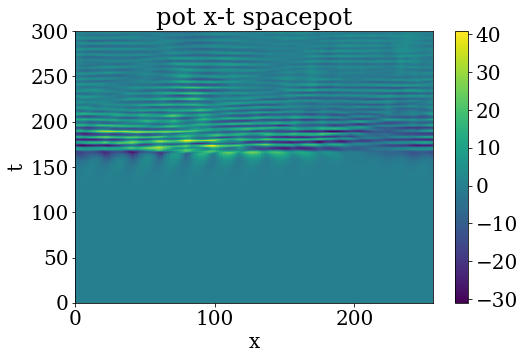

In [15]:
dirname = 'buneman'

#osiris.plot_wk_arb(rundir=dirname, field='pot', TITLE='potential',wlim=4, klim=3)
osiris.plot_xt_arb(rundir=dirname, field='pot',tlim=[0,300] )

## Finally, let's look at the electron phase space.

In [16]:
dirname='buneman'

osiris.phaseinteract_upic(rundir=dirname)

interactive(children=(IntSlider(value=37, description='n', max=74), Output()), _dom_classes=('widget-interact',))